In [351]:
from __future__ import division
import string
from ADMCode import visualize as vis
from ADMCode import qlearn
import numpy as np
import pandas as pd

# from ipywidgets import interactive
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.simplefilter('ignore', np.RankWarning)
warnings.filterwarnings("ignore", module="matplotlib")
warnings.filterwarnings("ignore")
sns.set(style='white', font_scale=1.3)

%matplotlib inline

# Q-learning
---
* **Q-update**: $$Q(a_i) \leftarrow  Q(a_i) + \alpha (r_t - Q(a_i))$$

* **Softmax policy**: $$P(a_i) = \frac{e^{\beta Q(a_i)}}{\sum_j^N e^{\beta Q(a_j)}}$$

## Q-agent

In [352]:
# alpha (float): 
#        learning rate
# beta (float): 
#        inverse temperature parameter 
# preward (list): 
#        1xN vector of reward probaiblities for each of N bandits
# rvalues (list): 
#        1xN vector of payout values for each of N bandits

agent = qlearn.Qagent(alpha=.1, beta=2, preward=[.85, .75, .65], rvalues=[1, 1, 1])

## Simulate a single agent

In [353]:
# play 500 trials of multi-armed bandit task
data1 = agent.play_bandits(ntrials=500, get_output=True)

## Check output dataframe

In [354]:
# Columns: 
#     trial: trial number
#     q0: Q-value (i.e., expected value) of first bandit
#     q1: Q-value of second bandit
#     q2: Q-value of third bandit
#     p0: soft-max probability of selecting first bandit
#     p1: soft-max probability of selecting second bandit
#     p2: soft-max probability of selecting third bandit
#     choice: chosen bandit
#     feedback: feedback value returned by chosen bandit

data1.head()

,trial,q0,q1,q2,p0,p1,p2,choice,feedback
0,1,0.00,0.0,0.100,0.3104,0.3104,0.3792,2,1
1,2,0.00,0.0,0.190,0.2888,0.2888,0.4223,2,1
2,3,0.00,0.0,0.171,0.2934,0.2934,0.4131,2,0
3,4,0.10,0.0,0.171,0.3366,0.2755,0.3879,0,1
4,5,0.19,0.0,0.171,0.3778,0.2584,0.3638,0,1


# Visualize Q and P values

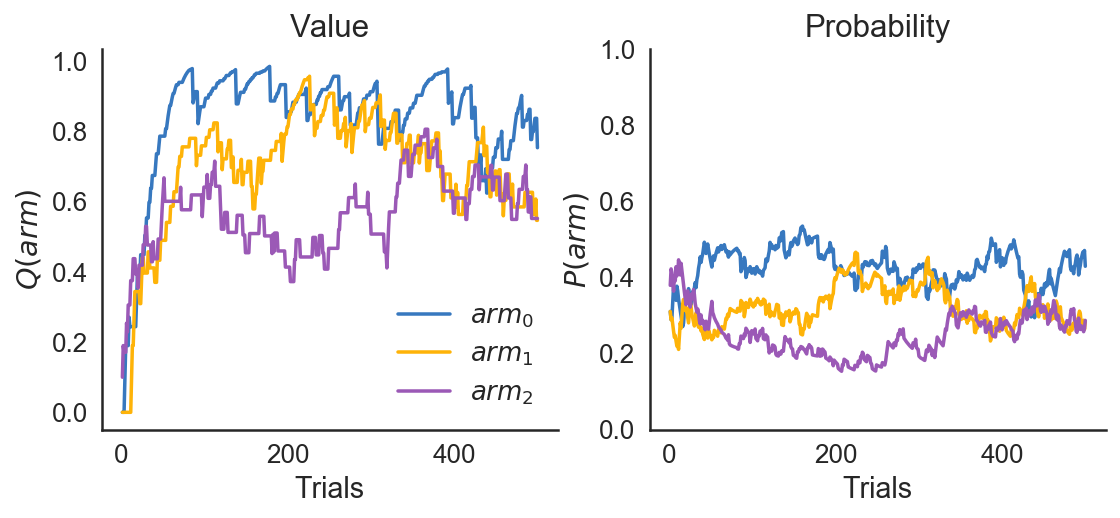

In [358]:
# plot Q-values and softmax selection prob. for each bandit
vis.plot_qlearning(data1)

# Simulate multiple identical agents

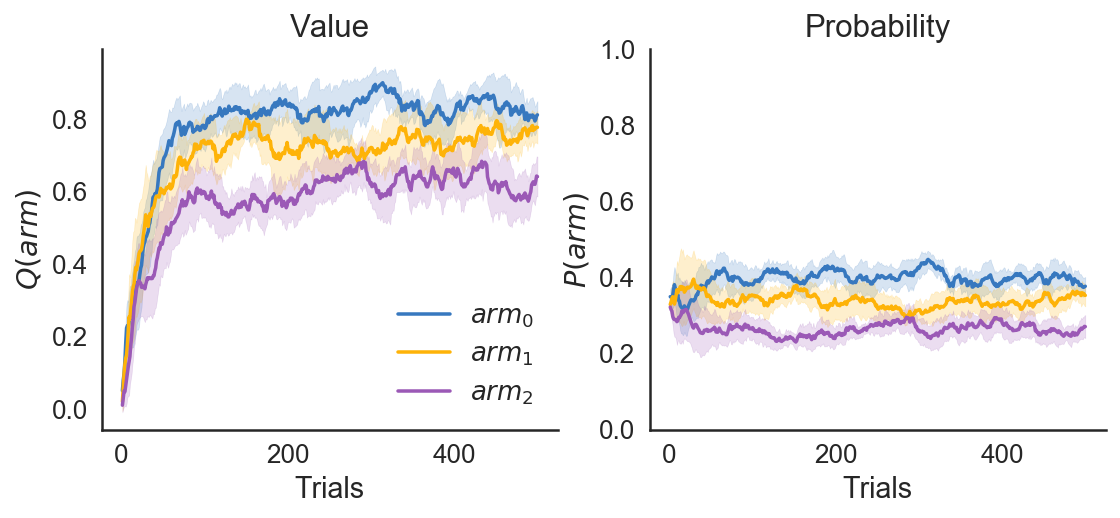

In [359]:
# simulate 10 different agents (same alpha, beta) 
data = agent.simulate_multiple_agents(nagents=10, ntrials=500)
# visualize mean and variance of Q-values and selection prob. across agents
vis.plot_qlearning(data)

# Q-learning code

In [348]:
def update_Qi(Qval, reward, alpha):
    return Qval + alpha*(reward - Qval)

def update_Pall(Qvector, beta):
    return np.array([np.exp(beta*Q_i) / np.sum(np.exp(beta * Qvector)) for Q_i in Qvector])


def play_bandits(alpha=.1, beta=.15, preward=[.8, .5, .2], ntrials=1000):
    """ defines the learning parameters of single q-learning agent
    as well as reward probabilities for each one-armed bandit in 
    a multi-armed bandit task

    ::Arguments::
        alpha (float): learning rate
        beta (float): inverse temperature parameter
        preward (list): 1xN vector of reward probaiblities for each of N bandits
        ntrials (int): number of trials to play bandits
    ::Returns::
        DataFrame (Ntrials x Nbandits) with trialwise Q and P values for each bandit
    """
    
    nact = len(preward)
    actions = np.arange(nact)  
    rvalues = np.ones(nact)
    bandits = qlearn.MultiArmedBandit(preward=preward, rvalues=rvalues)

    Qmatrix=np.zeros((ntrials, nact))
    Pmatrix=np.zeros_like(Qmatrix)
    
    Qvalues = Qmatrix[0, :]
    Pvalues = np.array([1/nact]*nact)

    for t in range(ntrials):

        # select bandit arm (action)
        act_i = np.random.choice(actions, p=Pvalues)

        # observe feedback
        r = bandits.get_feedback(act_i)

        # get expected value 
        Qexpected = Qvalues[act_i]
        
        # update expected value and store in Qvalues array
        # Qexpected + alpha * (r - Qexpected)
        Qvalues[act_i] = update_Qi(Qexpected, r, alpha)
        # update action selection probabilities 
        Pvalues = update_Pall(Qvalues, beta)
        
        # store new values in output matrices
        Qmatrix[t, :] = Qvalues
        Pmatrix[t, :] = Pvalues

    return make_output_df(Qmatrix, Pmatrix)  

def make_output_df(Qmatrix, Pmatrix):
    actions = np.arange(Qmatrix.shape[1])
    df = pd.concat([pd.DataFrame(dat) for dat in [Qmatrix, Pmatrix]], axis=1)
    cols = [['{}{}'.format(x,c) for c in actions] for x in ['q', 'p']]
    df.columns = np.hstack(cols)
    df.insert(0, 'trial', np.arange(1, df.shape[0]+1))
    return df

In [349]:
df = play_bandits(alpha=.1, beta=2, preward=[.85, .75, .65])

In [360]:
df.head()

,trial,q0,q1,q2,p0,p1,p2
0,1,0.6074,0.8425,0.647,0.3104,0.3792,0.3104
1,2,0.0000,0.1900,0.000,0.2888,0.4223,0.2888
2,3,0.0000,0.1900,0.100,0.2715,0.3970,0.3316
3,4,0.0000,0.1900,0.090,0.2733,0.3996,0.3272
4,5,0.1000,0.1900,0.090,0.3147,0.3768,0.3085
